In [3]:
import torch
import torch.nn.functional as F # for F.pad
from torch import nn

from torchvision.ops.misc import Permute
from torchvision.ops import StochasticDepth

import matplotlib.pyplot as plt
!pip install einops
from einops import rearrange

In [4]:
# stochastic depth 에 대해
class test_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.residual = nn.Conv2d(1,1,1, bias=False)
        self.stochastic_depth = StochasticDepth(0.3, "row") # 0.3이 죽일 확률 # "row"는 data 마다 다른 depth를 가지게 함!

    def forward(self,x):
        residual = self.residual(x)
        residual = self.stochastic_depth(residual)
        return x + residual

model=test_model()
x=torch.ones(2,1,2,2)
model.train()
print(model(x)) # 훈련 때는 1/(1-p) 을 residual에 곱한다
w=model.residual.weight.item()
print(round(1 + 1 * w/(1-0.3), 4))

model.eval()
print(model(x))
print(round(1 + 1 * w, 4)) # 테스트는 무시하지 않고 통과시킨다.
# stochastic depth는 드랍아웃을 node가 아닌 residual block에 적용했다고 생각할 수 있다.
# residual=0 이면 그냥 통과인거니까 identity mapping임. 따라서 depth 가 stochastic하다!
# stochastic depth 논문에서는 훈련 때는 랜덤하게 skip하고 테스트 때는 다 통과하되 1-p를 곱하는 것으로 설명 되어있다.
# 하지만 토치 구현에서는 반대로 train 땐 1/(1-p) 를 곱하고 테스트 때는 그냥 통과하는 것으로 구현!
# 드랍아웃도 이처럼 논문과 달리 train 땐 1/(1-p) 로 키워놓고 테스트 때는 그대로 나오게끔 구현되어있음

tensor([[[[1.3137, 1.3137],
          [1.3137, 1.3137]]],


        [[[1.3137, 1.3137],
          [1.3137, 1.3137]]]], grad_fn=<AddBackward0>)
1.3137
tensor([[[[1.2196, 1.2196],
          [1.2196, 1.2196]]],


        [[[1.2196, 1.2196],
          [1.2196, 1.2196]]]], grad_fn=<AddBackward0>)
1.2196


In [5]:
class FeedForward(nn.Module):
    def __init__(self, dim, d_ff, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(dim, d_ff),
                                    nn.GELU(),
                                    nn.Dropout(drop_p),
                                    nn.Linear(d_ff, dim))

    def forward(self, x):
        x = self.linear(x)
        return x

class PatchMerging(nn.Module):
    def __init__(self, dim):
        super().__init__()

        self.dim = dim
        self.norm = nn.LayerNorm(4*dim, eps=1e-5)
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False) # merging 할 때 torch.cat으로 channel 축으로 쌓기 때문에 4dim이 된다

    def forward(self, x): # 개행열채
        H, W, _ = x.shape[1:]
        x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2)) # 홀수면 한줄 패딩 시킴, 채행열 기준 lr tb front back 순 이므로 행열채에 대해서는 front back lr tb 가 된다
        x0 = x[..., 0::2, 0::2, :]  # 1행 1열들
        x1 = x[..., 1::2, 0::2, :]  # 2행 1열들
        x2 = x[..., 0::2, 1::2, :]  # 1행 2열들
        x3 = x[..., 1::2, 1::2, :]  # 2행 2열들
        x = torch.cat([x0, x1, x2, x3], -1)  # 개 행/2 열/2 4채

        x = self.norm(x) # concat 하고 나서 바로 LN 하므로 (즉, 2x2 묶고 + channel 축 으로 normalization 한다) conv 로는 구현이 불가능! 그래서 nn.Linear로
        x = self.reduction(x)  # 개 행/2 열/2 2채
        return x

class ShiftedWindowAttention(nn.Module):
    def __init__(self, dim, window_size, shift_size, num_heads, drop_p = 0.0):
        super().__init__()

        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads

        self.fc_q = nn.Linear(dim, dim)
        self.fc_k = nn.Linear(dim, dim)
        self.fc_v = nn.Linear(dim, dim)
        self.fc_o = nn.Linear(dim, dim)

        self.scale = torch.sqrt(torch.tensor(dim / num_heads))

        self.get_relative_position_bias()

    def get_relative_position_bias(self):

        B_hat = nn.Parameter(torch.zeros(self.num_heads, (2 * self.window_size[0] - 1), (2 * self.window_size[1] - 1)))
        nn.init.trunc_normal_(B_hat, std=0.02)

        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        H, W = torch.meshgrid(coords_h, coords_w)

        relative_coords_h = H.reshape(1,-1) - H.reshape(-1,1)
        relative_coords_w = W.reshape(1,-1) - W.reshape(-1,1)
        relative_position_index_h = relative_coords_h + self.window_size[0] - 1 # 인덱스가 0부터 시작하도록 6을 더해줌 (즉, "기준"의 좌표는 (6,6)임)
        relative_position_index_w = relative_coords_w + self.window_size[1] - 1

        self.B = B_hat[:, relative_position_index_h, relative_position_index_w]
        self.B = self.B.unsqueeze(0).unsqueeze(0)

    def forward(self, x):

        M0, M1 = self.window_size
        B, H, W, C = x.shape # 개행열채

        # window size의 배수가 되도록 padding
        pad_r = (M1 - W % M1) % M1
        pad_b = (M0 - H % M0) % M0
        x = F.pad(x, (0, 0, 0, pad_r, 0, pad_b)) # 채행열 기준 lr tb front back 순 이므로 행열채에 대해서는 front back lr tb 가 된다
        _, H_pad, W_pad, _ = x.shape

        # down sample 많이 돼서 window size보다 resolution이 더 작으면 shift 할 필요 없음
        shift_size = self.shift_size.copy()
        if H_pad <= M0:
            shift_size[0] = 0
        if W_pad <= M1:
            shift_size[1] = 0

        # cyclic shift
        if sum(shift_size) > 0:
            x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1]), dims=(1, 2))

        # MSA
        x = rearrange(x, '개 (윈0 M0) (윈1 M1) 차 -> 개 (윈0 윈1) (M0 M1) 차', M0=M0, M1=M1) # 개행(21)열(21)채 -> 개윈(9)단(49)차

        Q = self.fc_q(x) # 개윈(9)단(49)차
        K = self.fc_k(x)
        V = self.fc_v(x)

        Q = rearrange(Q, '개 윈 단 (헤 차) -> 개 윈 헤 단 차', 헤 = self.num_heads) # 개윈단차 -> 개윈헤단차
        K = rearrange(K, '개 윈 단 (헤 차) -> 개 윈 헤 단 차', 헤 = self.num_heads)
        V = rearrange(V, '개 윈 단 (헤 차) -> 개 윈 헤 단 차', 헤 = self.num_heads)

        attn = Q @ K.transpose(-2,-1)/self.scale # 개윈헤단단

        # add relative position bias
        attn = attn + self.B

        # generate attention mask
        if sum(shift_size) > 0:
            window_group_num = x.new_zeros(H_pad, W_pad) # x와 같은 데이터 타입과 디바이스에 올려진, H_pad 행 x W_pad 열인 행렬을 만듦
            h_slices = ((0, -M0), (-M0, -shift_size[0]), (-shift_size[0], None))
            w_slices = ((0, -M1), (-M1, -shift_size[1]), (-shift_size[1], None))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    window_group_num[h[0] : h[1], w[0] : w[1]] = count
                    count += 1
            window_group_num = rearrange(window_group_num, '(윈0 M0) (윈1 M1) -> (윈0 윈1) (M0 M1)', M0=M0, M1=M1)
            attn_mask = window_group_num.unsqueeze(2) - window_group_num.unsqueeze(1) # 9 x 49 x 49
            attn_mask[attn_mask != 0] = -1e10
            attn = attn + attn_mask.unsqueeze(1).unsqueeze(0) # + 1 9 1 49 49

        attn = F.softmax(attn, dim=-1) # 개윈헤단단

        attn = attn @ V # 개윈헤단차

        x = rearrange(attn, '개 윈 헤 단 차 -> 개 윈 단 (헤 차)') # 개윈헤단차 -> 개윈단차
        x = self.fc_o(x) # 개윈단차

        x = rearrange(x, '개 (윈0 윈1) (M0 M1) 차 -> 개 (윈0 M0) (윈1 M1) 차', 윈0=H_pad//M0, M0=M0) # 개윈(9)단(49)차 -> 개행(21)열(21)채

        # reverse cyclic shift
        if sum(shift_size) > 0:
            x = torch.roll(x, shifts=(shift_size[0], shift_size[1]), dims=(1, 2))

        # unpad features
        x = x[:, :H, :W, :]

        return x

class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size, shift_size, mlp_ratio = 4.0, drop_p = 0.0, stochastic_depth_prob = 0.0):
        super().__init__()

        self.SW_MSA_LN = nn.LayerNorm(dim, eps=1e-5)
        self.SW_MSA = ShiftedWindowAttention(dim, window_size, shift_size, num_heads, drop_p=drop_p)

        self.FF_LN = nn.LayerNorm(dim, eps=1e-5)
        self.FF = FeedForward(dim, int(dim * mlp_ratio), drop_p=drop_p)

        self.dropout = nn.Dropout(drop_p)
        self.stochastic_depth = StochasticDepth(stochastic_depth_prob, "row")

        # 초기화는 https://github.com/pytorch/vision/blob/main/torchvision/models/swin_transformer.py#L446 참고
        for m in self.FF.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)

    def forward(self, x):

        residual = self.SW_MSA_LN(x)
        residual = self.SW_MSA(residual)
        residual = self.dropout(residual)
        residual = self.stochastic_depth(residual)
        x = x + residual

        residual = self.FF_LN(x)
        residual = self.FF(residual)
        residual = self.dropout(residual)
        residual = self.stochastic_depth(residual)
        x = x + residual

        return x

class SwinTransformer(nn.Module):
    def __init__(self, patch_size, embed_dim, depths, num_heads, window_size, mlp_ratio = 4, drop_p = 0.0, stochastic_depth_prob = 0.1, num_classes = 1000):
        super().__init__()

        self.num_classes = num_classes

        layers = []
        # split image into non-overlapping patches
        layers += [nn.Sequential(nn.Conv2d(3, embed_dim, kernel_size=(patch_size[0], patch_size[1]), stride=(patch_size[0], patch_size[1])),
                                 Permute([0, 2, 3, 1]), # 여기서 개행열채로 바뀜. torch.permute() 를 쓰려면 forward 에서 해야하기 때문에 nn.Sequential() 안에 넣으려면 이렇게!
                                 nn.LayerNorm(embed_dim, eps=1e-5))]
                                 # https://github.com/pytorch/vision/blob/main/torchvision/models/swin_transformer.py#L561 여기 보면 norm 하고 block에서 또 norm 함

        total_stage_blocks = sum(depths)
        stage_block_id = 0
        # build SwinTransformer blocks
        for i_stage in range(len(depths)):
            stage = []
            dim = embed_dim * 2**i_stage
            for i_layer in range(depths[i_stage]):
                # adjust stochastic depth probability based on the depth of the stage block
                sd_prob = stochastic_depth_prob * stage_block_id / (total_stage_blocks - 1)
                stage += [SwinTransformerBlock(dim,
                                               num_heads[i_stage],
                                               window_size=window_size,
                                               shift_size=[0 if i_layer % 2 == 0 else w // 2 for w in window_size], # 한 번은 W-MSA, 한 번은 SW-MSA
                                               mlp_ratio=mlp_ratio,
                                               drop_p = drop_p,
                                               stochastic_depth_prob=sd_prob)]
                stage_block_id += 1
            layers += [nn.Sequential(*stage)]
            # add patch merging layer
            # https://github.com/pytorch/vision/blob/main/torchvision/models/swin_transformer.py#L590 참고
            # Stage 구성이 그림에서 Partition - [[ Linear Embedding - Swin Block ]] 이렇게 묶여있는데 코드에서는
            # 첫 conv - [[ Swin Block - Path Merging ]] 이렇게 묶이게끔 짜여져 있다)
            if i_stage < (len(depths) - 1):
                layers += [PatchMerging(dim)]
        self.features = nn.Sequential(*layers)

        # https://github.com/pytorch/vision/blob/main/torchvision/models/swin_transformer.py#L595 참고
        # LN - GAP - fc 로 되어있음.
        # ViT의 실험 중 CLS 토큰 안 쓰고 최종 인코더 아웃풋에 LN-GAP-fc 하는 방식을 Swin 에서는 기본 구조로 채택함!
        self.norm = nn.LayerNorm(dim, eps=1e-5)
        self.avgpool = nn.Sequential(Permute([0, 3, 1, 2]), # 개행열채 -> 개채행열
                                     nn.AdaptiveAvgPool2d((1,1)))
        self.fc = nn.Linear(dim, num_classes)

        # 초기화는 https://github.com/pytorch/vision/blob/main/torchvision/models/swin_transformer.py#L601 참고
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.norm(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [6]:
def swin_t(**kwargs): # 28288354
    return SwinTransformer(patch_size=[4, 4], embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24], window_size=[7, 7], stochastic_depth_prob=0.2, **kwargs)

def swin_s(**kwargs): # 49606258
    return SwinTransformer(patch_size=[4, 4], embed_dim=96, depths=[2, 2, 18, 2], num_heads=[3, 6, 12, 24], window_size=[7, 7], stochastic_depth_prob=0.3, **kwargs)

def swin_b(**kwargs): # 87768224
    return SwinTransformer(patch_size=[4, 4], embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32], window_size=[7, 7], stochastic_depth_prob=0.5, **kwargs)

def swin_l(**kwargs):
    return SwinTransformer(patch_size=[4, 4], embed_dim=192, depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48], window_size=[7, 7], stochastic_depth_prob=0.6, **kwargs)

In [7]:
model = swin_l()
!pip install torchinfo
from torchinfo import summary
summary(model, input_size=(2,3,224,224), device='cpu')

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Layer (type:depth-idx)                             Output Shape              Param #
SwinTransformer                                    [2, 1000]                 --
├─Sequential: 1-1                                  [2, 7, 7, 1536]           --
│    └─Sequential: 2-1                             [2, 56, 56, 192]          --
│    │    └─Conv2d: 3-1                            [2, 192, 56, 56]          9,408
│    │    └─Permute: 3-2                           [2, 56, 56, 192]          --
│    │    └─LayerNorm: 3-3                         [2, 56, 56, 192]          384
│    └─Sequential: 2-2                             [2, 56, 56, 192]          --
│    │    └─SwinTransformerBlock: 3-4              [2, 56, 56, 192]          444,864
│    │    └─SwinTransformerBlock: 3-5              [2, 56, 56, 192]          444,864
│    └─PatchMerging: 2-3                           [2, 28, 28, 384]          --
│    │    └─LayerNorm: 3-6                         [2, 28, 28, 768]          1,536
│    │    └─Linear

In [8]:
x = torch.randn(2,3,224,224)
print(model(x).shape)

torch.Size([2, 1000])


In [9]:
model.train()
print(model(x))
print(model(x))
model.eval()
print(model(x))
print(model(x))

tensor([[ 0.1314,  0.8953,  0.5835,  ..., -0.1897,  0.0781,  0.4803],
        [ 0.4279,  0.1742,  0.1758,  ..., -0.1596,  0.6098,  1.0524]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.3055,  0.2762,  0.5020,  ..., -0.1875,  0.5554, -0.5471],
        [ 0.5771, -0.2443,  0.5896,  ..., -0.3392,  1.3183, -0.2565]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.1682,  0.7888,  0.1625,  ..., -0.2031,  0.4773,  0.3328],
        [ 0.0449,  0.7178,  0.2955,  ..., -0.1545,  0.6339,  0.3092]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.1682,  0.7888,  0.1625,  ..., -0.2031,  0.4773,  0.3328],
        [ 0.0449,  0.7178,  0.2955,  ..., -0.1545,  0.6339,  0.3092]],
       grad_fn=<AddmmBackward0>)


In [10]:
# F.pad 실험
input = torch.randn(1, 5, 5, 3) # 개행열채
pad_r = 2
pad_b = 1
output = F.pad(input, (0, 0, 0, pad_r, 0, pad_b))
# pad size 는 left right (열) top bottom (행) front back (채) 순인데 채행열로 들어온다고 생각하기 때문에 행열채로 되어있는 현재 상황을 잘 생각해줘야..
# 즉, front back lr tb 순이 된다!

print(output.shape)

torch.Size([1, 21, 22, 3])


In [11]:
# pad_r, pad_b 가 어떻게 계산되는건지
M0, M1 = [7,7]
W = 20
H = 20
pad_r = (M1 - W % M1) % M1
pad_b = (M0 - H % M0) % M0
print(pad_r)
print(pad_b)

pad_r = (M1 - W % M1) # 배수 일 때는 pad=0 이여야 해서 마지막에 %M1 가 붙어야 함
pad_b = (M0 - H % M0)
print(pad_r)
print(pad_b)

1
1
1
1


In [12]:
# torch.roll 실험
x = torch.randint(0,6, (1,5,5,1))
print(x.squeeze())

shifted_x = torch.roll(x, shifts=(2, 0), dims=(1, 2)) # 아래로 두칸 이동
print(shifted_x.squeeze())

shifted_x = torch.roll(x, shifts=(-2, 0), dims=(1, 2)) # 위로 두칸 이동
print(shifted_x.squeeze())

shifted_x = torch.roll(x, shifts=(0, 2), dims=(1, 2)) # 오른쪽으로 두칸 이동
print(shifted_x.squeeze())

shifted_x = torch.roll(x, shifts=(0, -2), dims=(1, 2)) # 왼쪽으로 두칸 이동
print(shifted_x.squeeze())

shifted_x = torch.roll(x, shifts=(-2, -2), dims=(1, 2)) # 왼쪽 위로 두칸씩 이동
print(shifted_x.squeeze())

tensor([[5, 4, 5, 4, 4],
        [4, 4, 0, 4, 4],
        [4, 2, 3, 2, 0],
        [3, 1, 5, 2, 1],
        [2, 3, 0, 4, 1]])
tensor([[3, 1, 5, 2, 1],
        [2, 3, 0, 4, 1],
        [5, 4, 5, 4, 4],
        [4, 4, 0, 4, 4],
        [4, 2, 3, 2, 0]])
tensor([[4, 2, 3, 2, 0],
        [3, 1, 5, 2, 1],
        [2, 3, 0, 4, 1],
        [5, 4, 5, 4, 4],
        [4, 4, 0, 4, 4]])
tensor([[4, 4, 5, 4, 5],
        [4, 4, 4, 4, 0],
        [2, 0, 4, 2, 3],
        [2, 1, 3, 1, 5],
        [4, 1, 2, 3, 0]])
tensor([[5, 4, 4, 5, 4],
        [0, 4, 4, 4, 4],
        [3, 2, 0, 4, 2],
        [5, 2, 1, 3, 1],
        [0, 4, 1, 2, 3]])
tensor([[3, 2, 0, 4, 2],
        [5, 2, 1, 3, 1],
        [0, 4, 1, 2, 3],
        [5, 4, 4, 5, 4],
        [0, 4, 4, 4, 4]])


torch.Size([21, 21])


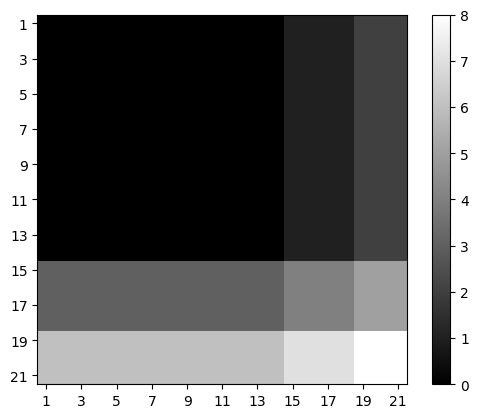

In [13]:
# 그룹 번호 매기기
M0, M1 = [7, 7]
shift_size = [3, 3]
H_pad = W_pad = 21
# num_windows = (H_pad // M0) * (W_pad // M1)

window_group_num = torch.zeros(H_pad, W_pad)
h_slices = ((0, -M0), (-M0, -shift_size[0]), (-shift_size[0], None))
w_slices = ((0, -M1), (-M1, -shift_size[1]), (-shift_size[1], None))
count = 0
for h in h_slices:
    for w in w_slices:
        window_group_num[h[0] : h[1], w[0] : w[1]] = count
        count += 1

print(window_group_num.shape)
plt.figure()
plt.imshow(window_group_num, cmap='gray')
plt.xticks(range(0,W_pad,2), range(1,W_pad+1,2))
plt.yticks(range(0,H_pad,2), range(1,H_pad+1,2))
plt.colorbar()
plt.show()

In [14]:
# 각 윈도우 별로(행) group number(열)가 적힌 행렬 만들기
window_group_num = rearrange(window_group_num, '(윈0 M0) (윈1 M1) -> (윈0 윈1) (M0 M1)', M0=M0, M1=M1) # 21x21 -> 9x49
print(window_group_num.shape)
print(window_group_num)
# attn_mask 만들기 (9개 윈도우 별로 행마다 우리조야 아니야? 우리조면 0 다른 조면 0 아닌 값을 쌓음)
attn_mask = window_group_num.unsqueeze(2) - window_group_num.unsqueeze(1)
print(attn_mask.shape)
attn_mask[attn_mask != 0] = -1e10

torch.Size([9, 49])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1.,
         2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 1.,
         1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   

In [24]:
# 윗 셀에서 window_group_num.unsqueeze(2) - window_group_num.unsqueeze(1) 어떤 식으로 빼지는 건지 확인
window_group_num_test = torch.tensor([[0, 0, 0, 0], [1, 2, 1, 2], [3, 3, 6, 6], [4, 5, 7, 8]])
attn_mask_test = window_group_num_test.unsqueeze(2) - window_group_num_test.unsqueeze(1)
print(window_group_num_test)
print(window_group_num_test.unsqueeze(2))
print(window_group_num_test.unsqueeze(1))
print(attn_mask_test)

tensor([[0, 0, 0, 0],
        [1, 2, 1, 2],
        [3, 3, 6, 6],
        [4, 5, 7, 8]])
tensor([[[0],
         [0],
         [0],
         [0]],

        [[1],
         [2],
         [1],
         [2]],

        [[3],
         [3],
         [6],
         [6]],

        [[4],
         [5],
         [7],
         [8]]])
tensor([[[0, 0, 0, 0]],

        [[1, 2, 1, 2]],

        [[3, 3, 6, 6]],

        [[4, 5, 7, 8]]])
tensor([[[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],

        [[ 0, -1,  0, -1],
         [ 1,  0,  1,  0],
         [ 0, -1,  0, -1],
         [ 1,  0,  1,  0]],

        [[ 0,  0, -3, -3],
         [ 0,  0, -3, -3],
         [ 3,  3,  0,  0],
         [ 3,  3,  0,  0]],

        [[ 0, -1, -3, -4],
         [ 1,  0, -2, -3],
         [ 3,  2,  0, -1],
         [ 4,  3,  1,  0]]])


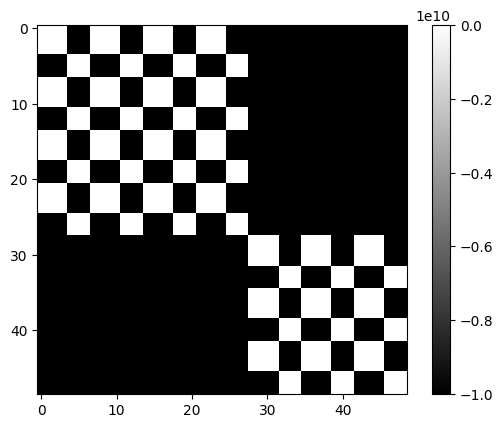

In [39]:
# 0~8 번째 윈도우까지 (한 픽셀 기준으로 나머지 49개 픽셀에 대해서 누구랑 attention 해야할 지가 하얗게 나온다 => 같은 조 애들에만 attention!)
plt.figure()
plt.imshow(attn_mask[8], cmap='gray')
plt.colorbar()
plt.show()

In [45]:
# relative position bias 만들기
window_size = (7,7)
B_hat = nn.Parameter(torch.zeros(4, (2 * window_size[0] - 1), (2 * window_size[1] - 1))) # 4 는 num_heads가 올자리
nn.init.trunc_normal_(B_hat, std=0.02)
print(B_hat.shape)

torch.Size([4, 13, 13])


In [46]:
coords_h = torch.arange(window_size[0])
coords_w = torch.arange(window_size[1])

H, W = torch.meshgrid(coords_h, coords_w)
print(H)
print(W)

tensor([[0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6, 6]])
tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])


In [47]:
# relative position bias 만들기 (continued)
relative_coords_h = H.reshape(1,-1) - H.reshape(-1,1)
relative_coords_w = W.reshape(1,-1) - W.reshape(-1,1)

print(W.reshape(1,-1))
print(W.reshape(-1,1))
print(relative_coords_h)
print(relative_coords_w)
print(relative_coords_h.shape)
print(relative_coords_w.shape)

tensor([[0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2,
         3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5,
         6]])
tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6]])
tensor([[ 0,  0,  0,  ...,  6,  6,  6],
        [ 0,  0,  0,  ...,  6,  6,  6],
        [ 0,  0,  0,  ...,  6,  6,  6],
        ...,
        [-6, -6, -6,  ...,  0,  0,  0],
        [-6, 

In [48]:
# relative position bias 만들기 (continued)
relative_position_index_h = relative_coords_h + window_size[0] - 1 # 인덱스가 0부터 시작하도록 6을 더해줌 (즉, "기준"의 좌표는 (6,6)임)
relative_position_index_w = relative_coords_w + window_size[1] - 1

print(relative_position_index_h)
print(relative_position_index_w)

tensor([[ 6,  6,  6,  ..., 12, 12, 12],
        [ 6,  6,  6,  ..., 12, 12, 12],
        [ 6,  6,  6,  ..., 12, 12, 12],
        ...,
        [ 0,  0,  0,  ...,  6,  6,  6],
        [ 0,  0,  0,  ...,  6,  6,  6],
        [ 0,  0,  0,  ...,  6,  6,  6]])
tensor([[ 6,  7,  8,  ..., 10, 11, 12],
        [ 5,  6,  7,  ...,  9, 10, 11],
        [ 4,  5,  6,  ...,  8,  9, 10],
        ...,
        [ 2,  3,  4,  ...,  6,  7,  8],
        [ 1,  2,  3,  ...,  5,  6,  7],
        [ 0,  1,  2,  ...,  4,  5,  6]])


In [56]:
# relative position bias 만들기 (continued)
B = B_hat[:, relative_position_index_h, relative_position_index_w] # B_hat.shape = 헤(2M-1)(2M-1), B.shape = 헤단단
B = B.unsqueeze(0).unsqueeze(0) # 헤단단 -> 11헤단단, 이걸 개윈헤단단과 더하면 알아서 11->개윈으로 복제됨(broadcasting)
print(B_hat.shape)
print(B.shape) # 개윈헤단단 (데이터끼리, 윈도우끼리는 B가 다르지 않음. 헤드마다, 레이어마다 다름)
print(B)

torch.Size([4, 13, 13])
torch.Size([1, 1, 4, 49, 49])
tensor([[[[[ 0.0011, -0.0150, -0.0279,  ...,  0.0279, -0.0219, -0.0218],
           [-0.0268,  0.0011, -0.0150,  ...,  0.0149,  0.0279, -0.0219],
           [-0.0230, -0.0268,  0.0011,  ..., -0.0030,  0.0149,  0.0279],
           ...,
           [-0.0021,  0.0606, -0.0125,  ...,  0.0011, -0.0150, -0.0279],
           [ 0.0070, -0.0021,  0.0606,  ..., -0.0268,  0.0011, -0.0150],
           [-0.0272,  0.0070, -0.0021,  ..., -0.0230, -0.0268,  0.0011]],

          [[-0.0182,  0.0110,  0.0067,  ...,  0.0031,  0.0223, -0.0012],
           [ 0.0022, -0.0182,  0.0110,  ..., -0.0332,  0.0031,  0.0223],
           [ 0.0028,  0.0022, -0.0182,  ...,  0.0220, -0.0332,  0.0031],
           ...,
           [ 0.0232, -0.0230,  0.0210,  ..., -0.0182,  0.0110,  0.0067],
           [-0.0445,  0.0232, -0.0230,  ...,  0.0022, -0.0182,  0.0110],
           [-0.0357, -0.0445,  0.0232,  ...,  0.0028,  0.0022, -0.0182]],

          [[ 0.0260, -0.0211, -0.0

In [57]:
# 인덱싱 방법 모음. 위 셀에서는 2-2 방식을 사용한 것 (속에 텐서 들어가도 됨)
A=torch.tensor([[1,2,6],[3,4,7],[5,6,2],[7,8,9]])
print(A)
print(A.shape)

# 1. A[몇 번째 행이냐, 몇 번째 열이냐]
# print(A[0,1])
# 2-1. A[[몇 번째 행이냐,몇 번째 행이냐], [몇 번째 열이냐,몇 번째 열이냐]]
# print(A[ [0,2,3,1,2], [1,1,0,0,0] ])
# 2-2. A[ [[몇 번째 행이냐], [몇 번째 행이냐]], [[몇 번째 열이냐], [몇 번째 열이냐]] ] => 결과가 행렬 형태가 되도록 인덱싱!
print(A[  [[0, 2], [3, 1]],  [[0, 2], [1, 0]]  ])
# 3. A[ tensor(bool) ] => A와 같은 shape을 가지는 tensor형 bool이 어디에 True를 가지고 있냐
# print(A[ torch.tensor([[False,True,True],[False,False,False],[False,False,True],[False,True,False]]) ])
# print(A[A==2]) # 마스킹같은 걸 할 수 있음
# 4. A[몇 번째 값에 True가 있냐, 몇 번째 값에 True가 있냐]
# print(A[[True,False,False,False],[False,True,True]])
# 5. A[ tensor ] => 몇 번째 것을 어떻게 쌓을거냐
# print(A[ torch.tensor([1,1,2,2,2]) ])

tensor([[1, 2, 6],
        [3, 4, 7],
        [5, 6, 2],
        [7, 8, 9]])
torch.Size([4, 3])
tensor([[1, 2],
        [8, 3]])


In [23]:
# B_hat 과 비교 확인
print(B[0,0,0,0,0]) # 개윈헤단단
print(B_hat[0,6,6]) # 헤단단, 자기 자신과 내적에 대한 bias는 B_hat의 6,6에 존재

print(B[0,0,0,0,1])
print(B_hat[0,6,7]) # 한칸 오른쪽

print(B[0,0,0,0,7]) # 맨 윗줄이 0~6 이므로 한 칸 아래는 7 번째
print(B_hat[0,7,6]) # 한 칸 아래는 B_hat의 7,6에 존재

tensor(0.0123, grad_fn=<SelectBackward0>)
tensor(0.0123, grad_fn=<SelectBackward0>)
tensor(-0.0199, grad_fn=<SelectBackward0>)
tensor(-0.0199, grad_fn=<SelectBackward0>)
tensor(0.0080, grad_fn=<SelectBackward0>)
tensor(0.0080, grad_fn=<SelectBackward0>)
